Momentum is useful for optimizing machine learning models because it can improve the speed, stability, and accuracy of gradient descent. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
import time
from torchvision import datasets 

In [2]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '13355'

    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()
    
class LungColonCancerDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(LungColonCancerDataset, self).__init__(root=root_dir, transform=transform)
        
def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

    
train_losses = []
valid_losses = []
valid_accuracies = []
epoch_times = []  # List to store epoch durations

In [3]:
def train(rank, world_size, batch_size):
    setup(rank, world_size)

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    data_dir = '/home/hindupur.v/varsha_hpp/dataset/lung_colon_image_set'
    
    # Dataset setup
    train_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'train'), transform=transform)
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of training images (Rank {rank}): {len(train_dataset)}\n")

    validation_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'valid'), transform=transform)
    validation_sampler = DistributedSampler(validation_dataset, num_replicas=world_size, rank=rank)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of validation images (Rank {rank}): {len(validation_dataset)}\n")

    test_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'test'), transform=transform)
    test_sampler = DistributedSampler(test_dataset, num_replicas=world_size, rank=rank)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of test images (Rank {rank}): {len(test_dataset)}\n")

    # Initialize the model
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    num_ftrs = model.fc.in_features
    num_classes = 5
    model.fc = nn.Linear(num_ftrs, num_classes)  # 5 classes
    
    # Wrap the model with DistributedDataParallel
    ddp_model = nn.parallel.DistributedDataParallel(model)
    print(f"[Rank {rank}] Model initialized and wrapped in DDP.\n")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)
    
    print(f"[Rank {rank}] Optimizer and loss function are set up.\n")

    num_epochs = 10
    
    start_time = time.time()  # Start timing
    print("start_time", start_time)

    for epoch in range(num_epochs):
        ddp_model.train() 
        epoch_start_time = time.time()  # Start time for the epoch
        running_loss = 0.0
        epoch_train_losses = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = ddp_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"[Rank {rank}] Epoch {epoch+1} Batch {batch_idx+1}: Loss {loss.item()}\n")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}\n')
        
        epoch_duration = time.time() - epoch_start_time  # Calculate duration of the epoch
        epoch_times.append(epoch_duration)  # Append epoch duration to the list
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds\n")

        ddp_model.eval()  # Setting model to evaluate mode
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = ddp_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(validation_loader)
        epoch_accuracy = correct.double() / len(validation_dataset)

        valid_losses.append(epoch_val_loss)
        valid_accuracies.append(epoch_accuracy)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n')

        
    # Plot learning curves
    plot_learning_curves(train_losses, valid_losses, valid_accuracies)
    
    cleanup()
    
    end_time = time.time()  # End timing
    print("total end_time", end_time)
    
    duration = end_time - start_time
    print(f"Rank {rank}: Training duration: {duration:.2f} seconds")
    
    # saving the model for later use without disturbing the rest of the code
    torch.save(model.state_dict(), 'lung_colon_cancer_model_on_28_CPU.pth')

#     return ddp_model, train_losses, valid_losses, valid_accuracies, epoch_times

Number of training images (Rank 14): 20000
Number of training images (Rank 15): 20000


Number of training images (Rank 8): 20000
Number of training images (Rank 26): 20000


Number of training images (Rank 24): 20000
Number of training images (Rank 17): 20000

Number of training images (Rank 6): 20000


Number of training images (Rank 12): 20000
Number of training images (Rank 4): 20000
Number of training images (Rank 27): 20000
Number of training images (Rank 13): 20000

Number of training images (Rank 18): 20000

Number of training images (Rank 3): 20000
Number of training images (Rank 7): 20000
Number of training images (Rank 19): 20000
Number of training images (Rank 23): 20000
Number of training images (Rank 25): 20000
Number of training images (Rank 5): 20000
Number of training images (Rank 16): 20000

Number of training images (Rank 10): 20000








Number of training images (Rank 9): 20000

Number of training images (Rank 2): 20000

Number of training images (Rank 11): 20000

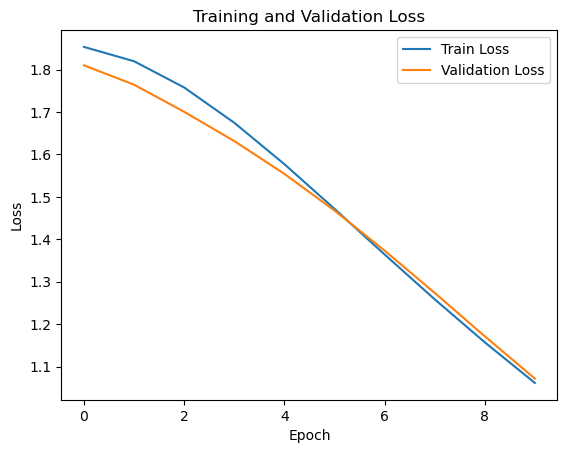


[Rank 21] Epoch 10/10, Val Loss: 1.0568, Accuracy: 0.0228

[Rank 20] Epoch 10/10, Val Loss: 1.0769, Accuracy: 0.0224


[Rank 4] Epoch 10/10, Val Loss: 1.0155, Accuracy: 0.0236
[Rank 26] Epoch 10/10, Val Loss: 0.9756, Accuracy: 0.0264


[Rank 3] Epoch 10/10, Val Loss: 1.0900, Accuracy: 0.0220


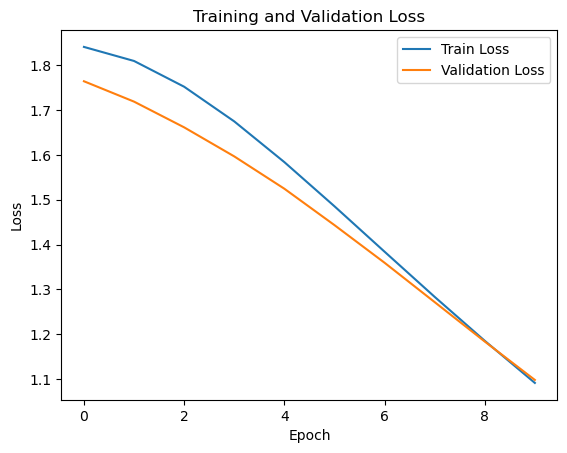

[Rank 8] Epoch 10/10, Val Loss: 1.0412, Accuracy: 0.0240


[Rank 27] Epoch 10/10, Val Loss: 1.0666, Accuracy: 0.0216



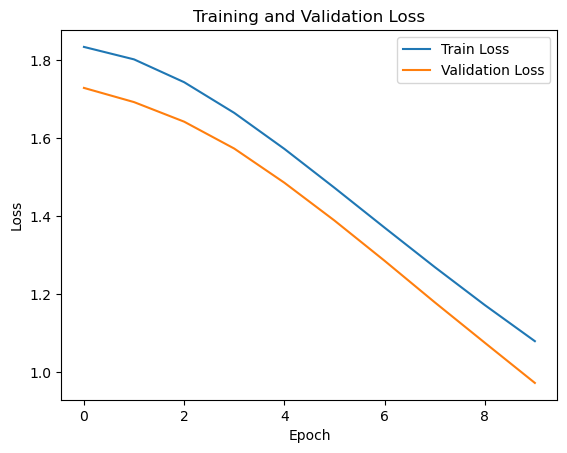

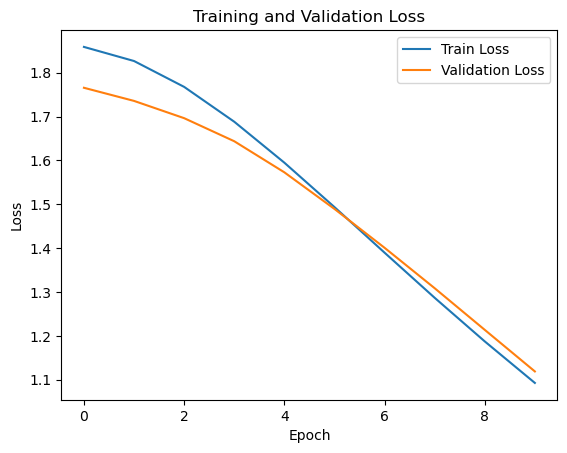

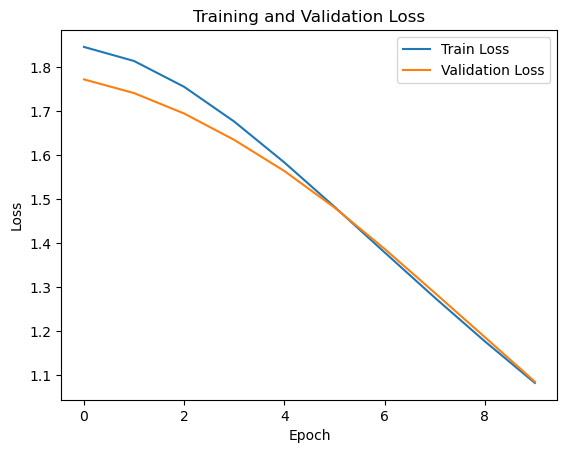

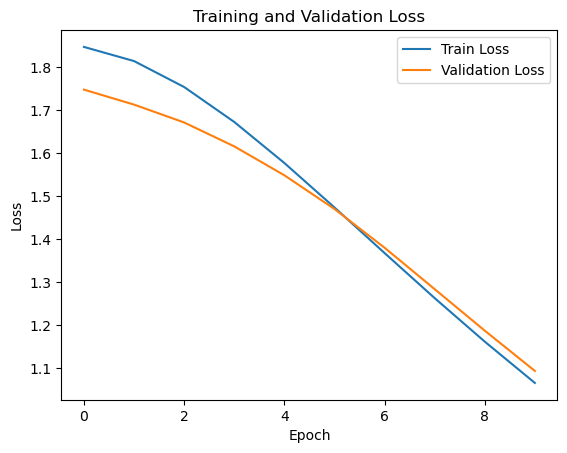

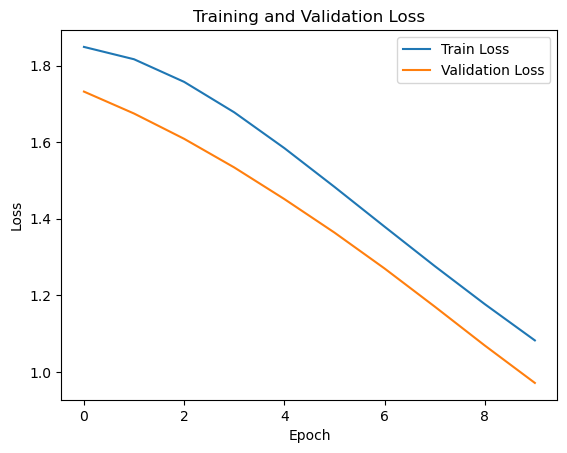

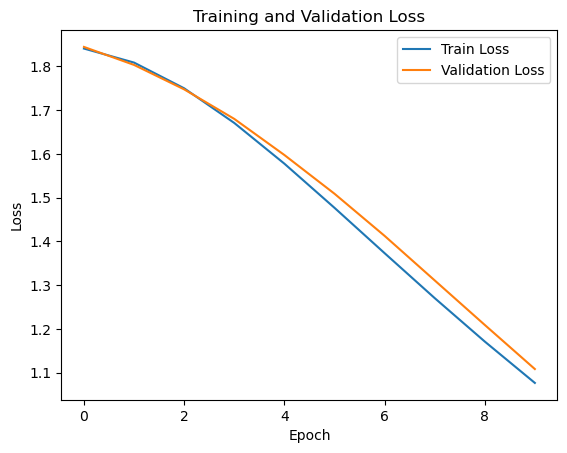

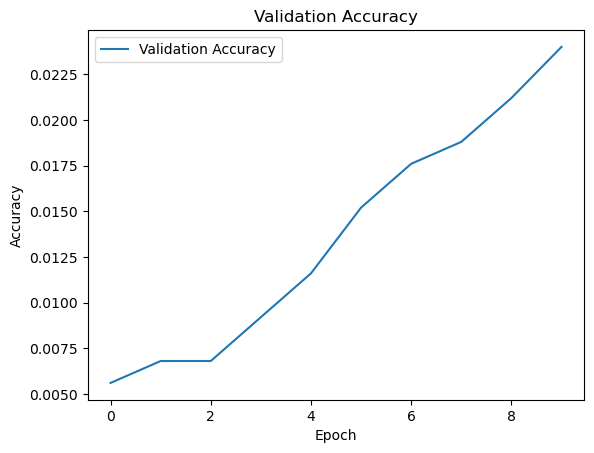

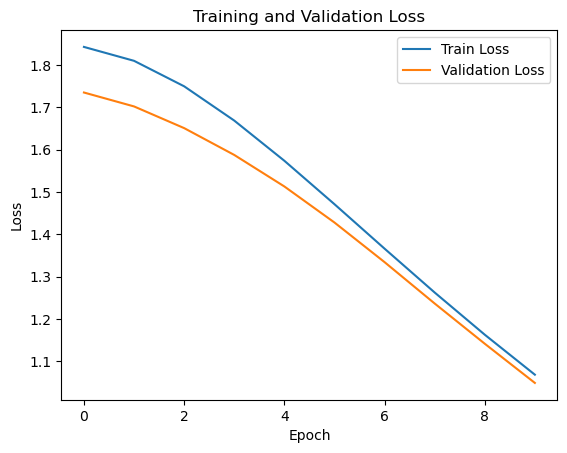

[Rank 1] Epoch 10/10, Val Loss: 1.0031, Accuracy: 0.0244
total end_time

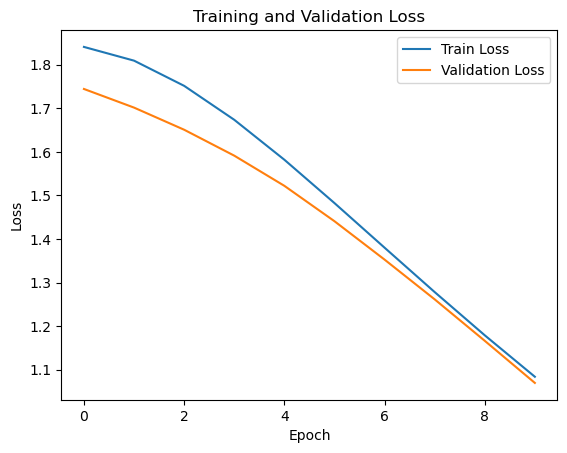

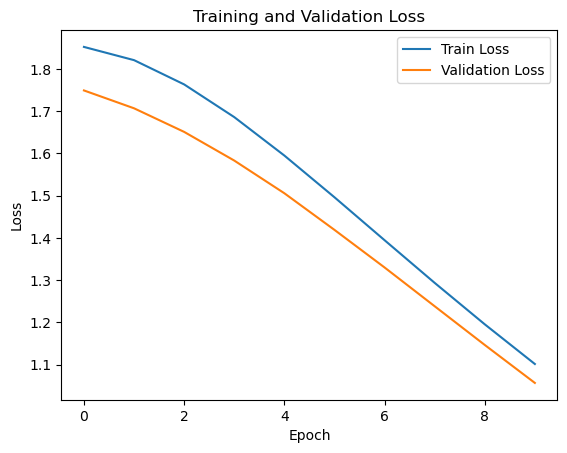

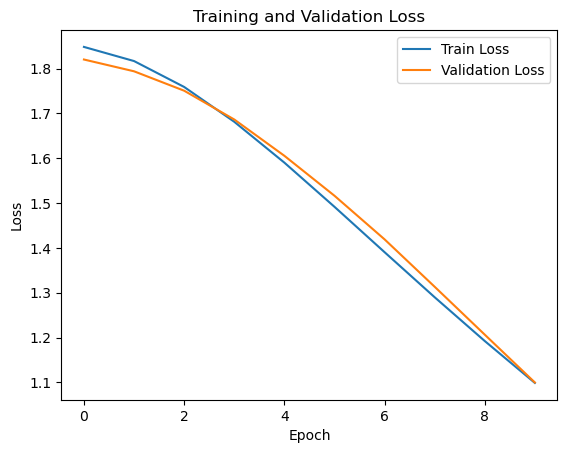

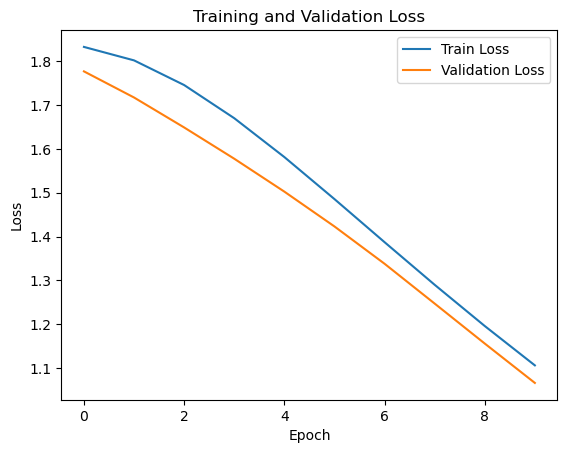

1713032178.5340521

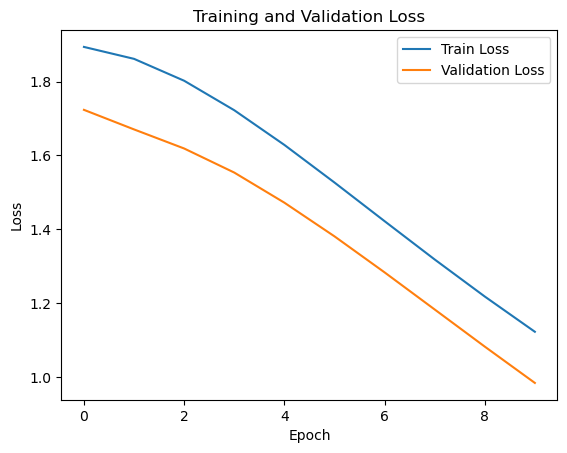


Rank 22: Training duration: 1533.83 seconds

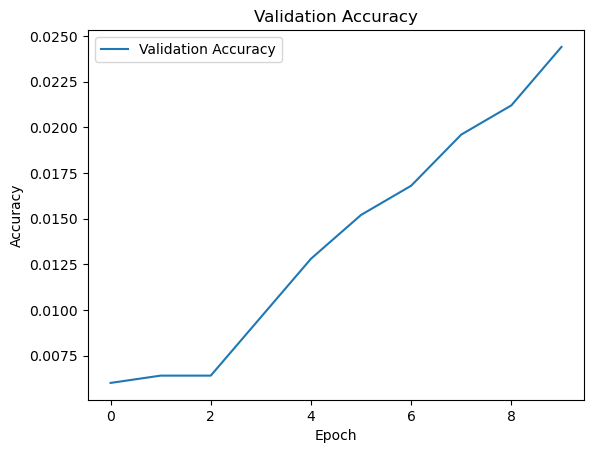


total end_time 

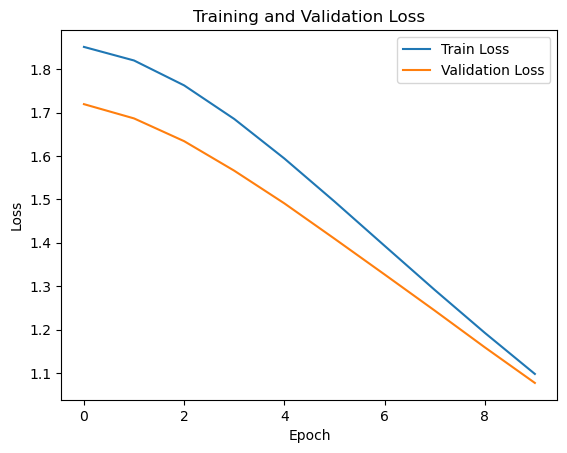

1713032178.5919604


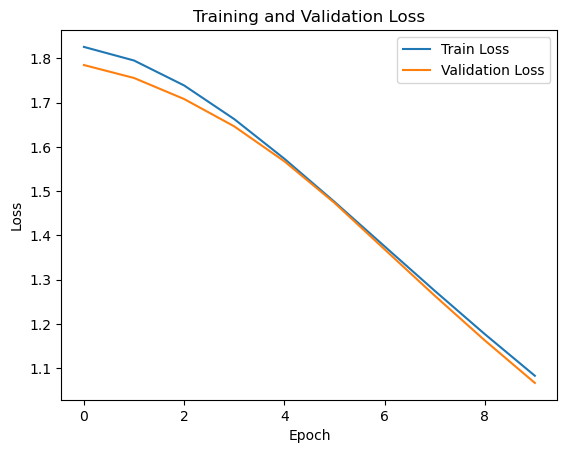

Rank 13: Training duration: 1533.36 seconds

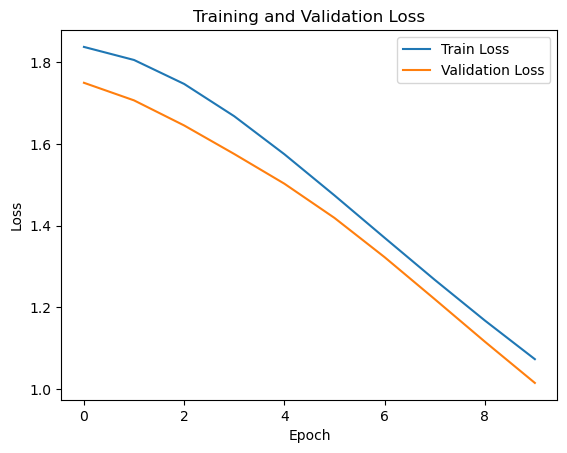

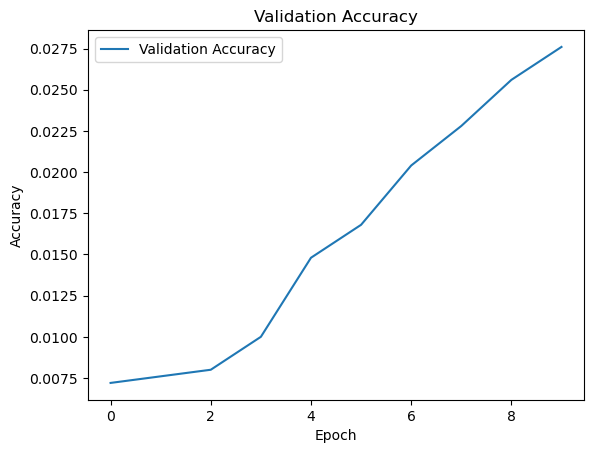

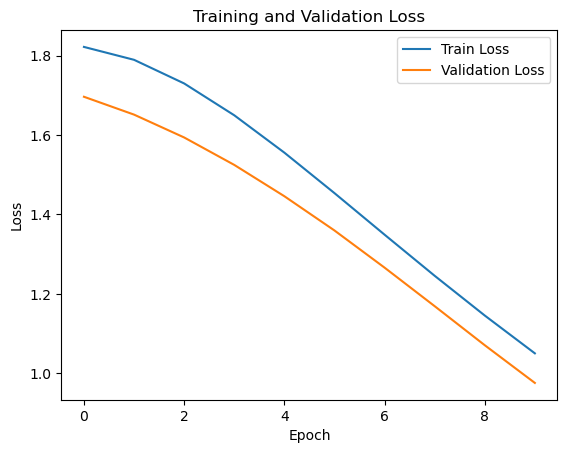

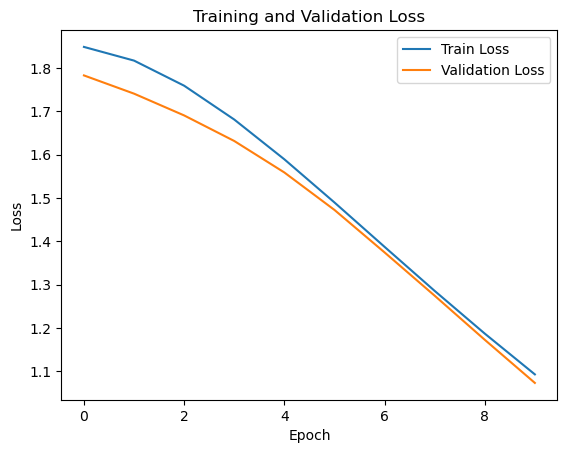

total end_time

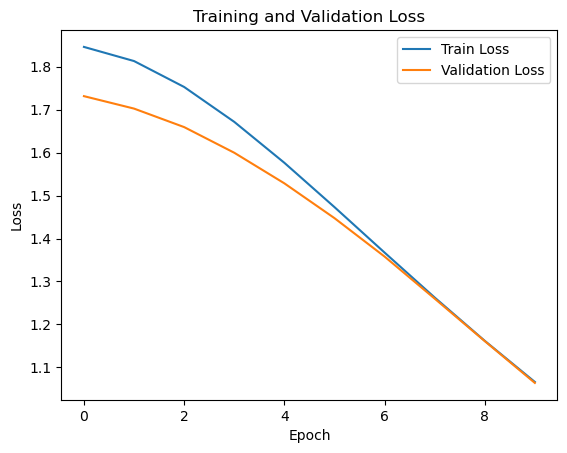

 1713032178.6083658


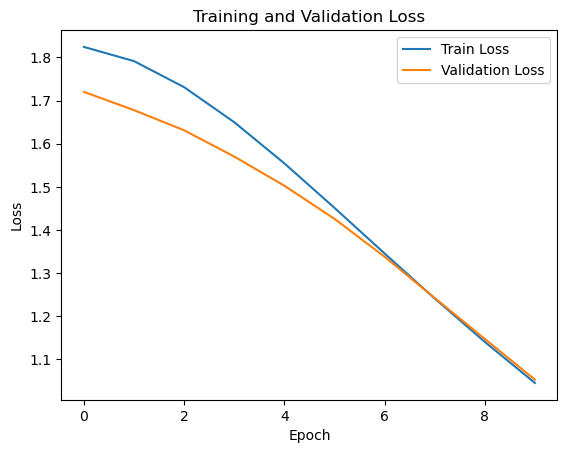

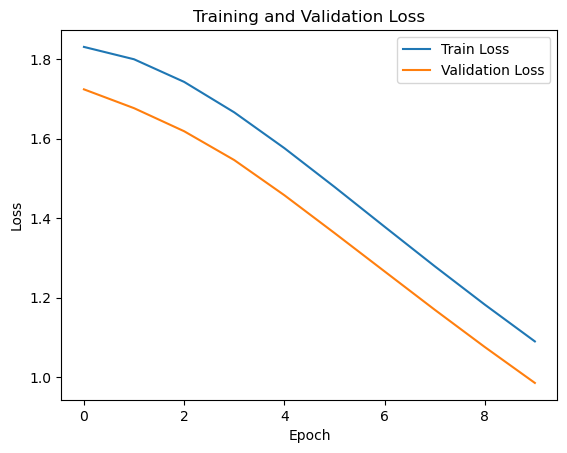

Rank 11: Training duration: 1532.72 seconds


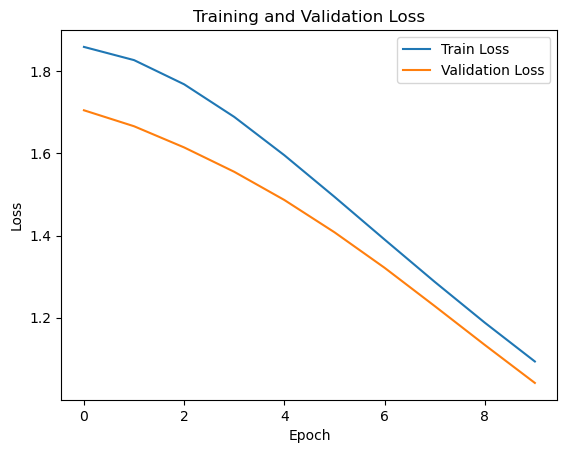

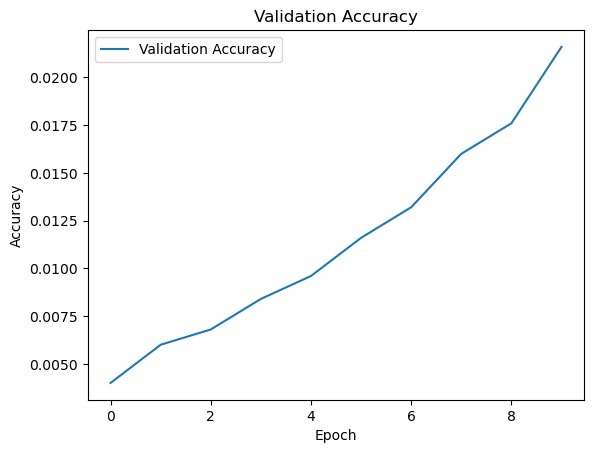

total end_time 1713032178.6260922
Rank 18: Training duration: 1533.64 seconds


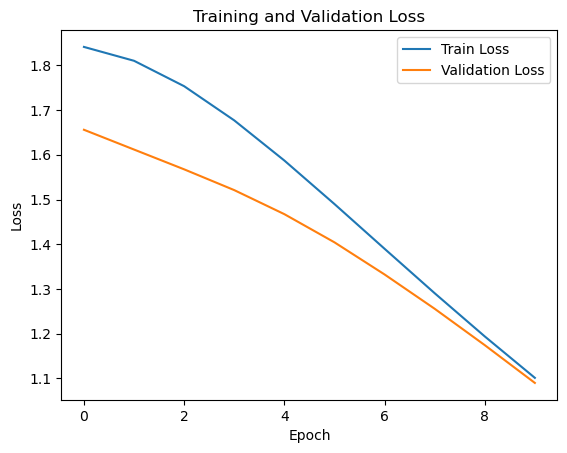

[Rank 25] Epoch 10/10, Val Loss: 1.0642, Accuracy: 0.0252



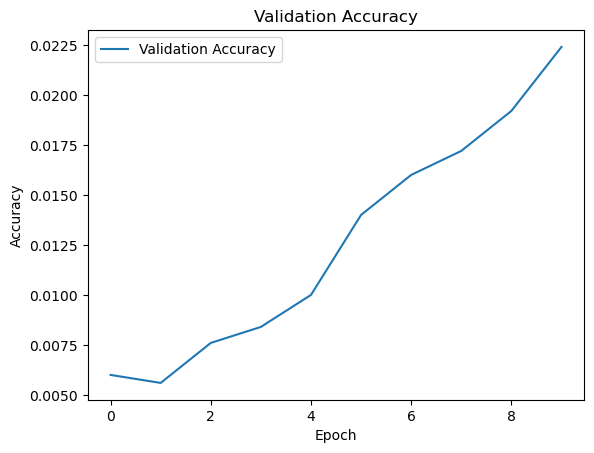

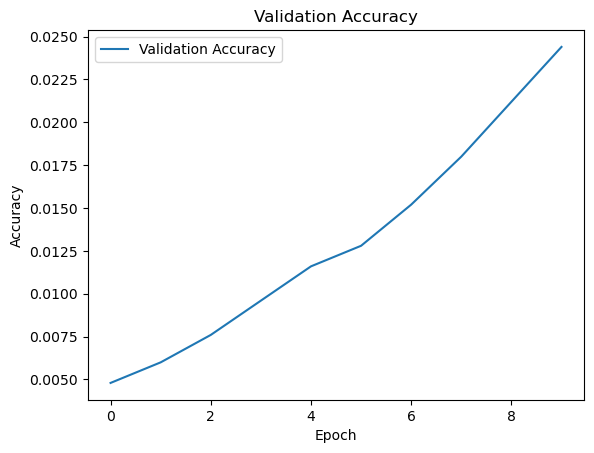

total end_timetotal end_time 1713032178.65371
Rank 24: Training duration: 1533.84 seconds


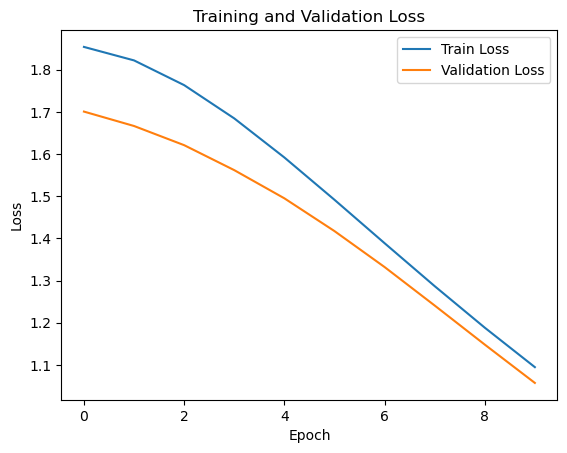

 1713032178.6537712
Rank 19: Training duration: 1533.12 seconds


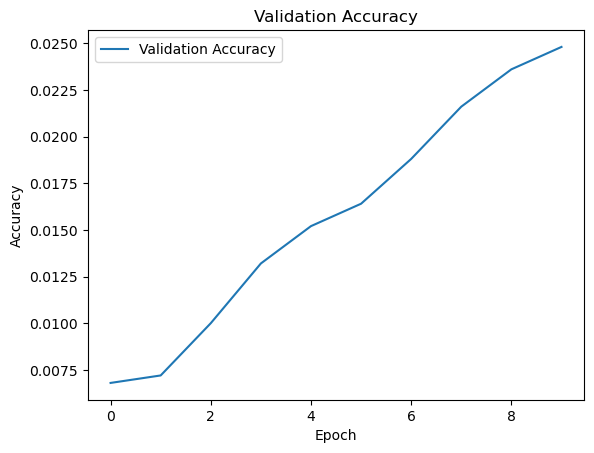

total end_time 1713032178.6660125
[Rank 9] Epoch 10/10, Val Loss: 1.0971, Accuracy: 0.0228
Rank 17: Training duration: 1532.39 seconds



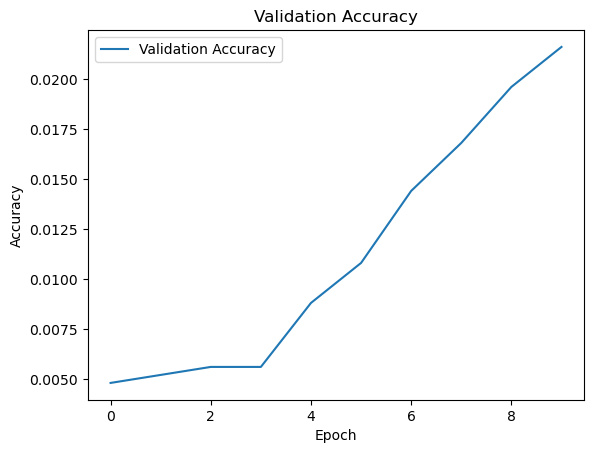

total end_time 1713032178.6916625
Rank 0: Training duration: 1534.05 seconds


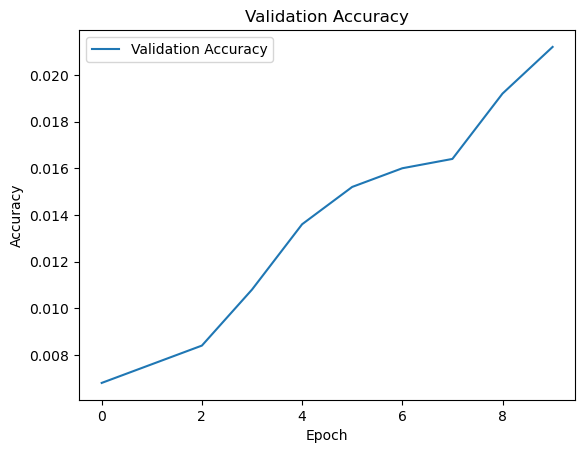

total end_time 1713032178.7123437
Rank 12: Training duration: 1534.01 seconds


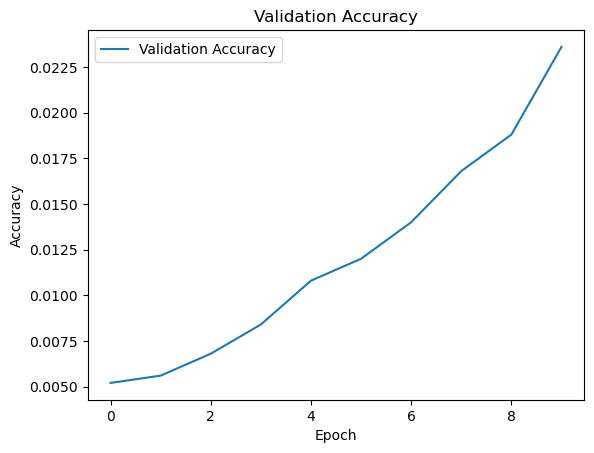

total end_time 1713032178.72672
Rank 5: Training duration: 1533.27 seconds

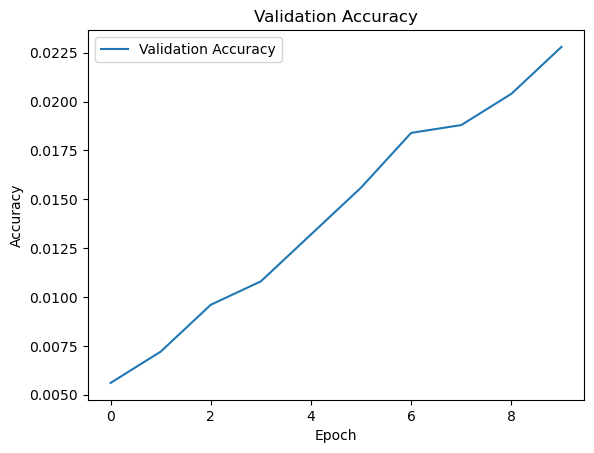


total end_time 1713032178.7302327
Rank 21: Training duration: 1534.29 seconds


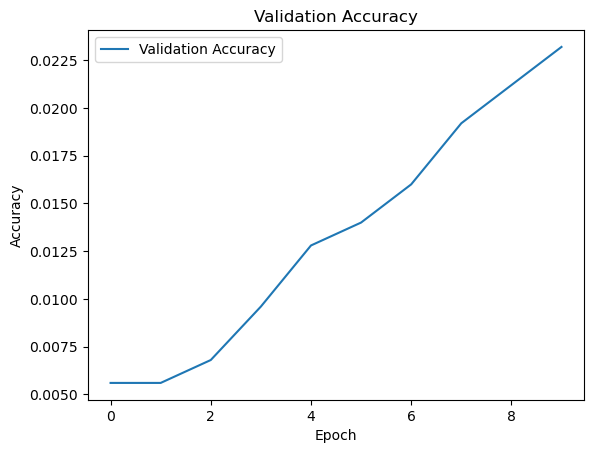

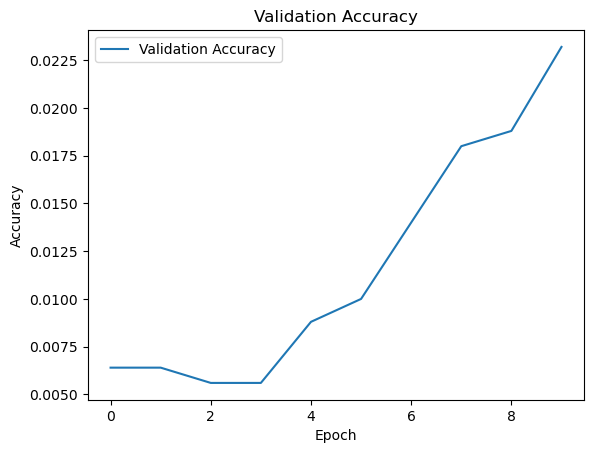

total end_time 

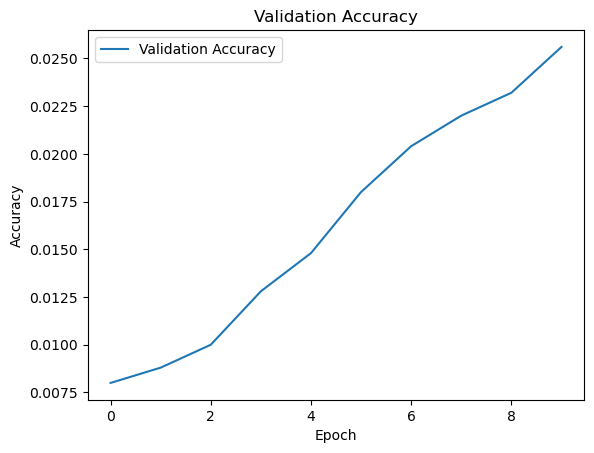

1713032178.7419426
Rank 10: Training duration: 1532.88 seconds
total end_time 1713032178.7500484

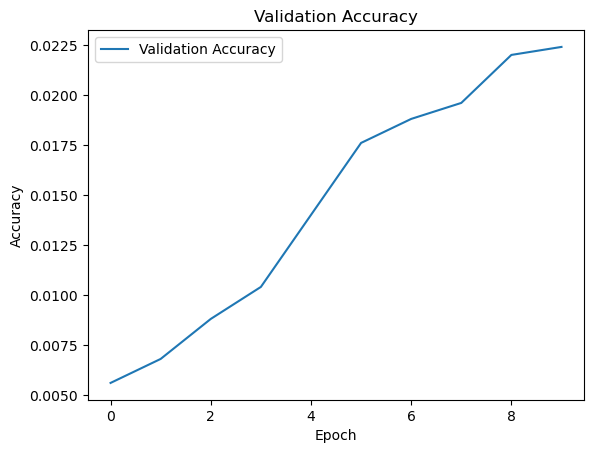

total end_time
Rank 7: Training duration: 1532.93 seconds 
total end_time1713032178.7520146
 Rank 23: Training duration: 1533.03 seconds1713032178.7532854

Rank 20: Training duration: 1533.88 seconds


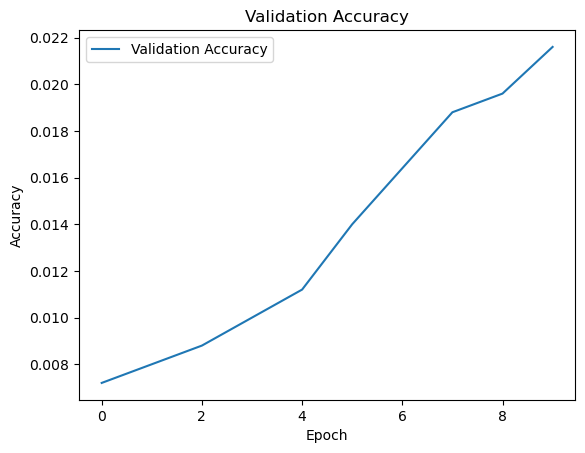

total end_time 1713032178.7595787
Rank 27: Training duration: 1533.11 seconds

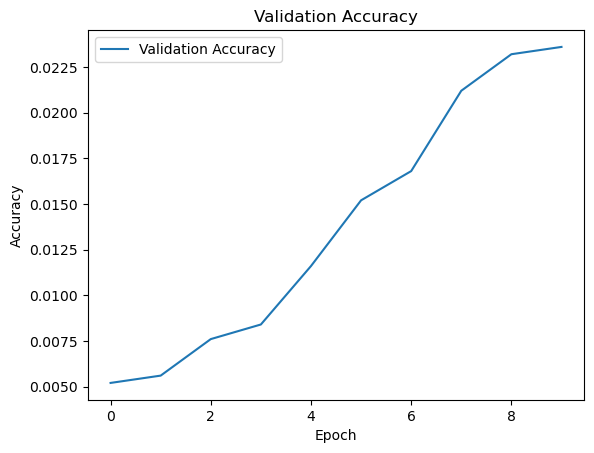

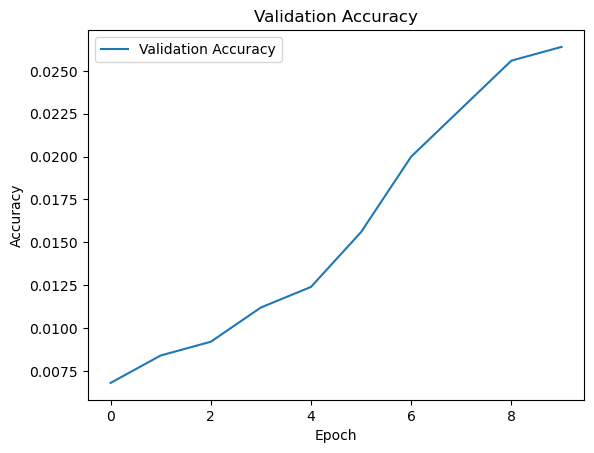

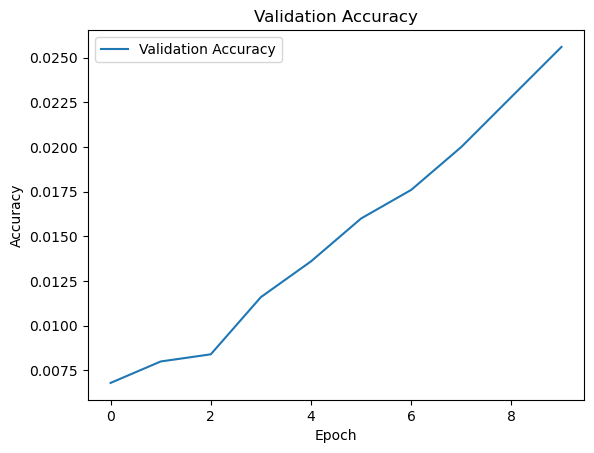

total end_timetotal end_timetotal end_time  

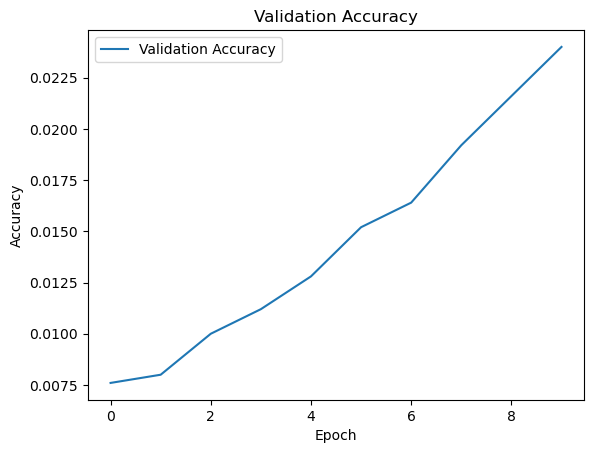

 1713032178.76473671713032178.7638085

Rank 15: Training duration: 1532.98 seconds1713032178.7649524Rank 4: Training duration: 1533.91 seconds
total end_time



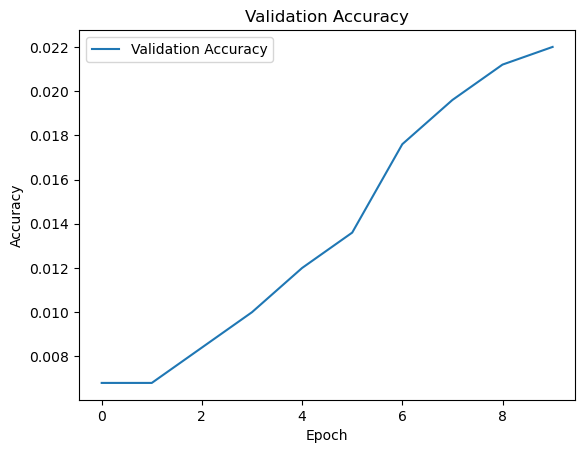

 Rank 26: Training duration: 1533.87 seconds1713032178.7673566

total end_timeRank 8: Training duration: 1534.61 seconds 
1713032178.7691913
Rank 16: Training duration: 1534.16 seconds

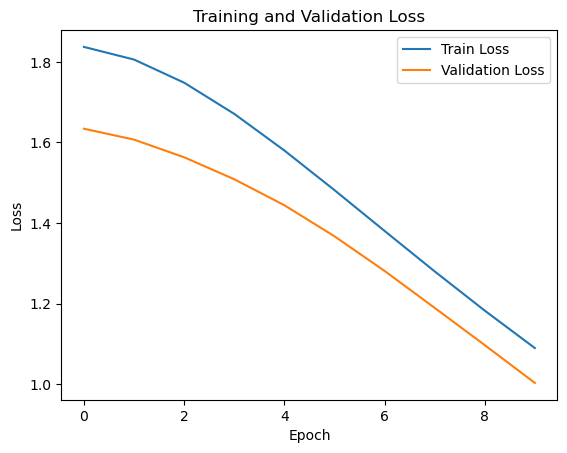

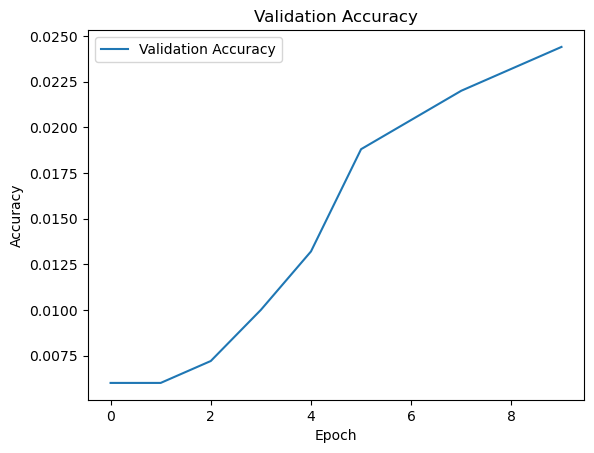

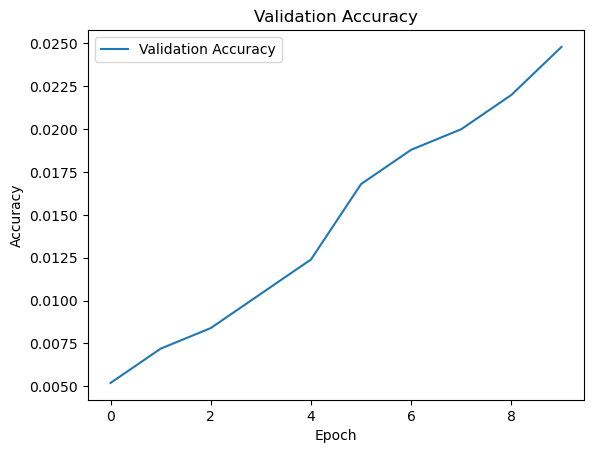

total end_time 1713032178.7751658
Rank 14: Training duration: 1533.68 seconds
total end_time 1713032178.7778964
Rank 2: Training duration: 1534.58 seconds


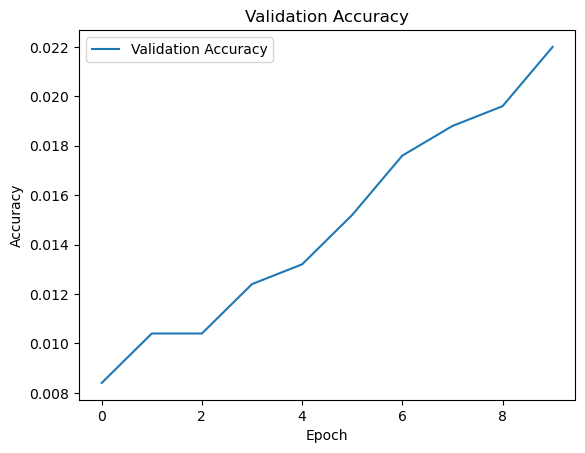

total end_time 1713032178.7945704
Rank 3: Training duration: 1533.24 seconds


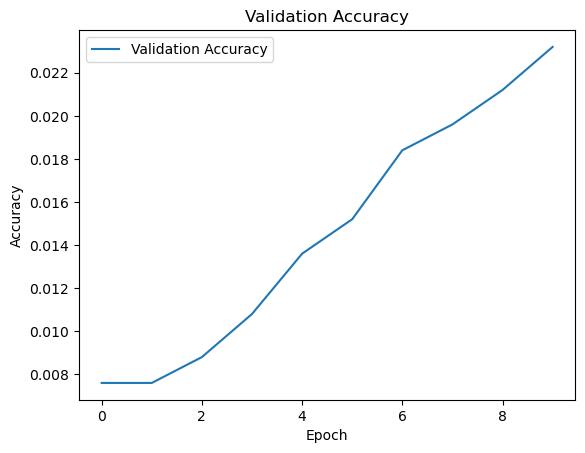

total end_time 1713032178.8217576
Rank 6: Training duration: 1533.02 seconds


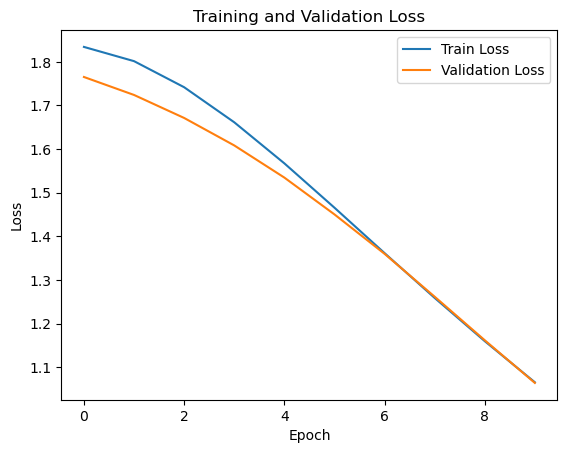

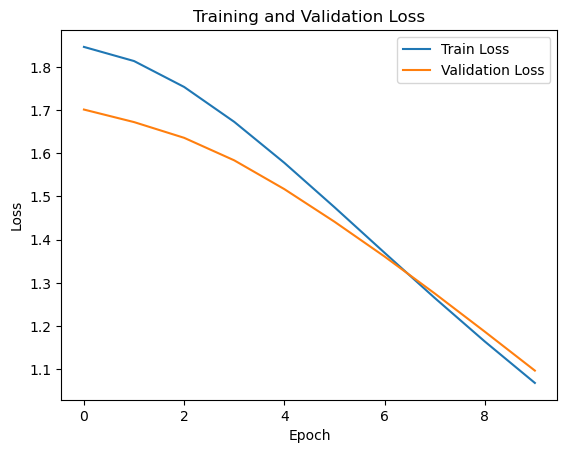

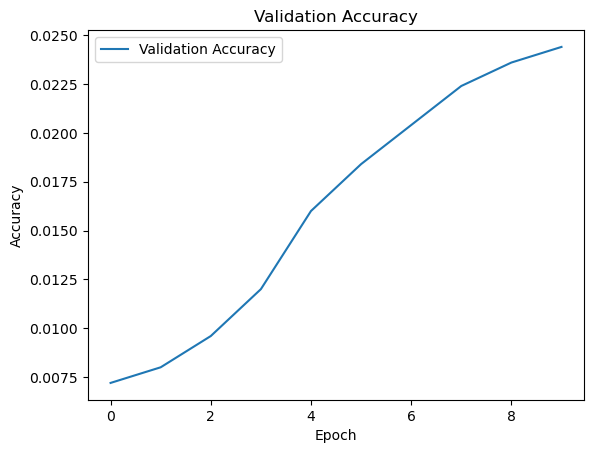

total end_time 1713032178.9332662
Rank 1: Training duration: 1533.25 seconds


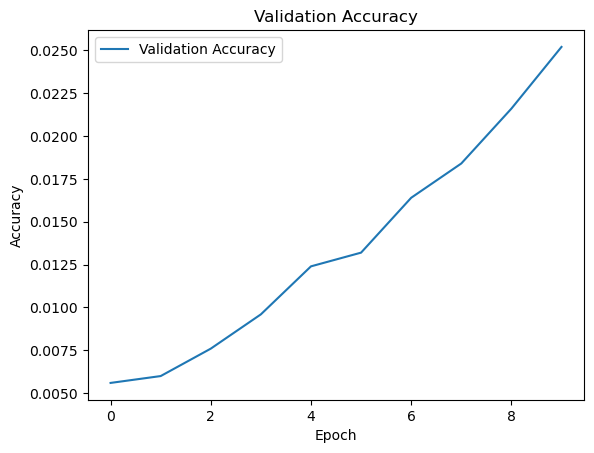

total end_time 1713032179.0006893
Rank 25: Training duration: 1532.16 seconds


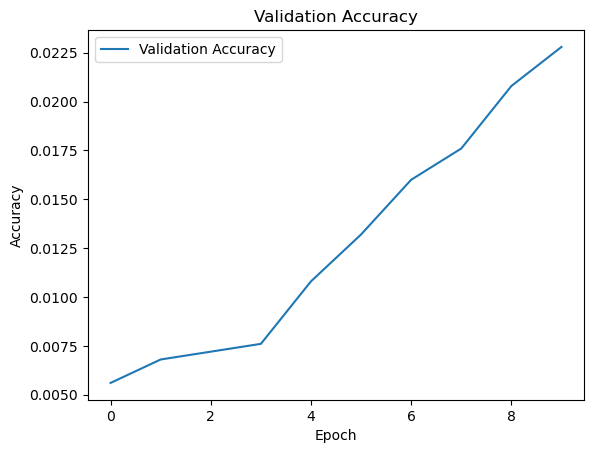

total end_time 1713032179.0136096
Rank 9: Training duration: 1533.55 seconds


In [4]:
if __name__ == '__main__':
    world_size = 28
    batch_size = 10000
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=train, args=(rank, world_size, batch_size))
        p.start() 
        processes.append(p)
    for p in processes:
        p.join()

Conclusion:

The Average duration for Epoch 1 is approximately 139.38 seconds.

The average duration for the 2nd epoch is approximately 137.45 seconds.

The average duration for the 3rd epoch is approximately 131.92 seconds.

4th Epoch: Approximately 130.27 seconds

5th Epoch: Approximately 129.90 seconds

Epoch 6:
Total number of loss values: 28
Sum of loss values: 41.515
Average loss for Epoch 6: 41.515 / 28 ≈ 1.483

Epoch 7:
Total number of loss values: 28
Sum of loss values: 38.712

Epoch 8:
Training Loss: Ranges from approximately 1.240 to 1.320 across different ranks.
Validation Loss: Ranges from approximately 1.170 to 1.313.
Training Duration: Varies between approximately 129 to 135 seconds per epoch.

Epoch 9:
Training Loss: Ranges from approximately 1.140 to 1.218 across different ranks.
Validation Loss: Ranges from approximately 1.070 to 1.287.
Training Duration: Varies between approximately 127 to 138 seconds per epoch.

Epoch 10:
Training Loss: Ranges from approximately 1.045 to 1.122 across different ranks.
Validation Loss: Ranges from approximately 0.971 to 1.118.
Training Duration: Varies between approximately 128 to 134 seconds per epoch.

### The average training duration for all 10 epochs is approximately 130.42 seconds.